# 1. Загрузка и анализ данных

In [1]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from torchvision.models import resnet18
from torchvision.models import vgg16
import torch.optim.lr_scheduler as lr_scheduler

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!mkdir -p data

!cp drive/MyDrive/Netology/netology_dl_sem/test.zip data/
!cp drive/MyDrive/Netology/netology_dl_sem/train.zip data/

!unzip -o -qq data/test.zip -d data/
!unzip -o -qq data/train.zip -d data/
!rm -rf data/simpsons_dataset/simpsons_dataset

In [4]:
data_dir = "data/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels)

print(f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}")

Изображений в train: 14653
Изображений в val: 6280


In [5]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


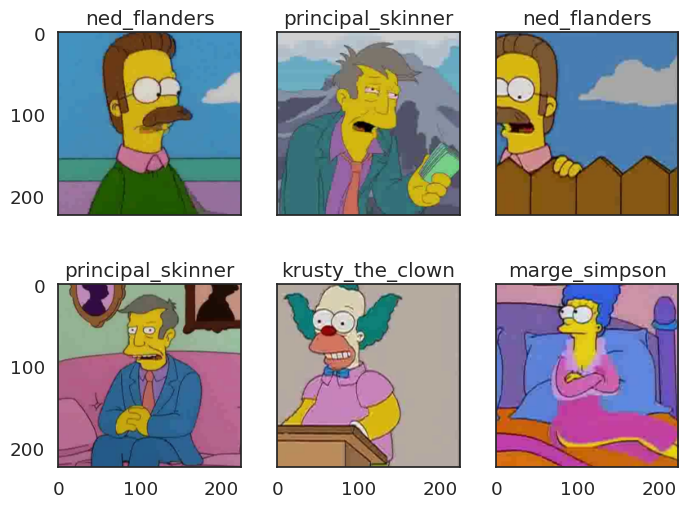

In [6]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

show_images(val_dataset)

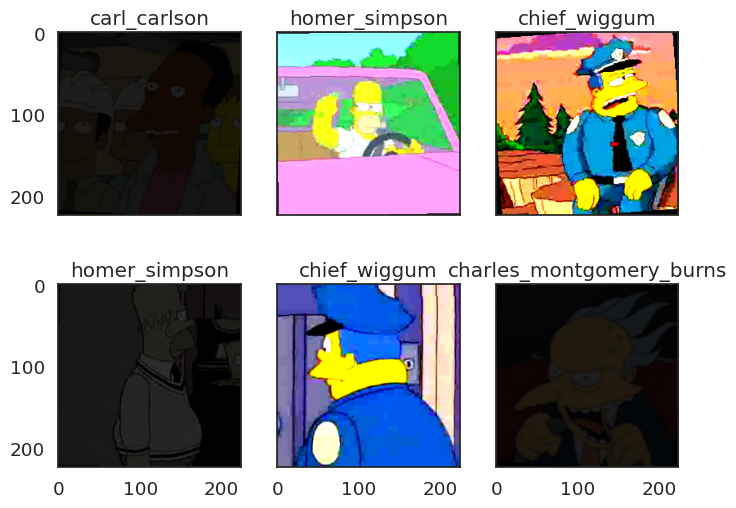

In [7]:
show_images(train_dataset)

# 2. Код обучения модели

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
def plot_learning_curves(history):
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [10]:
def train(model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=10):
    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [11]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 3. LR Schedulers

In [ ]:
def train_lr_schedulers(model, criterion, optimizer, scheduler, train_batch_gen, val_batch_gen, num_epochs=10):
    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        lr_1 = optimizer.param_groups[0]['lr']
        scheduler.step()
        lr_2 = optimizer.param_groups[0]['lr']

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        print("  lr: \t\t\t\t\t{:.4f} -> {:.4f}".format(lr_1, lr_2))

    return model, history

## ExponentialLR

In [ ]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler_1 = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

clf_model, history = train_lr_schedulers(
    model, criterion, optimizer, scheduler_1,
    train_batch_gen, val_batch_gen,
    num_epochs=3
)

Epoch 1 of 3 took 5025.321s
  training loss (in-iteration): 	3.113153
  validation loss (in-iteration): 	2.950128
  training accuracy: 			11.13 %
  validation accuracy: 			16.62 %
  lr: 					0.0100 -> 0.0090
Epoch 2 of 3 took 4399.821s
  training loss (in-iteration): 	2.928987
  validation loss (in-iteration): 	2.744954
  training accuracy: 			16.45 %
  validation accuracy: 			22.36 %
  lr: 					0.0090 -> 0.0081
Epoch 3 of 3 took 4369.208s
  training loss (in-iteration): 	2.779354
  validation loss (in-iteration): 	2.537804
  training accuracy: 			21.66 %
  validation accuracy: 			29.25 %
  lr: 					0.0081 -> 0.0073


## LinearLR

In [ ]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler_2 = lr_scheduler.LinearLR(optimizer, start_factor=0.5, total_iters=4)

clf_model, history = train_lr_schedulers(
    model, criterion, optimizer, scheduler_2,
    train_batch_gen, val_batch_gen,
    num_epochs=3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1 of 3 took 5066.313s
  training loss (in-iteration): 	3.171791
  validation loss (in-iteration): 	3.065240
  training accuracy: 			10.57 %
  validation accuracy: 			11.36 %
  lr: 					0.0050 -> 0.0063
Epoch 2 of 3 took 4770.571s
  training loss (in-iteration): 	3.031904
  validation loss (in-iteration): 	2.953128
  training accuracy: 			12.98 %
  validation accuracy: 			16.98 %
  lr: 					0.0063 -> 0.0075
Epoch 3 of 3 took 4779.351s
  training loss (in-iteration): 	2.930869
  validation loss (in-iteration): 	2.762061
  training accuracy: 			17.13 %
  validation accuracy: 			21.21 %
  lr: 					0.0075 -> 0.0088


# 4. Аугментация train

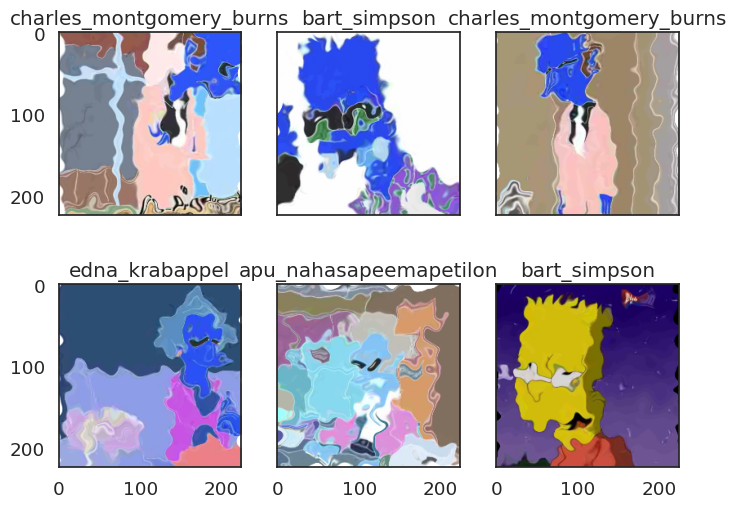

In [ ]:
train_transform_augm = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ElasticTransform(alpha=250.0),
    transforms.RandomInvert(0.9),
    transforms.CenterCrop(input_size),
    transforms.ToTensor()])

train_dataset_augm = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform_augm,
    is_valid_file=lambda x: x in train_files_path)

train_batch_gen_augm = torch.utils.data.DataLoader(train_dataset_augm, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

show_images(train_dataset_augm)

Epoch 7 of 10 took 1133.971s
  training loss (in-iteration): 	1.258430
  validation loss (in-iteration): 	2.250145
  training accuracy: 			66.78 %
  validation accuracy: 			39.43 %


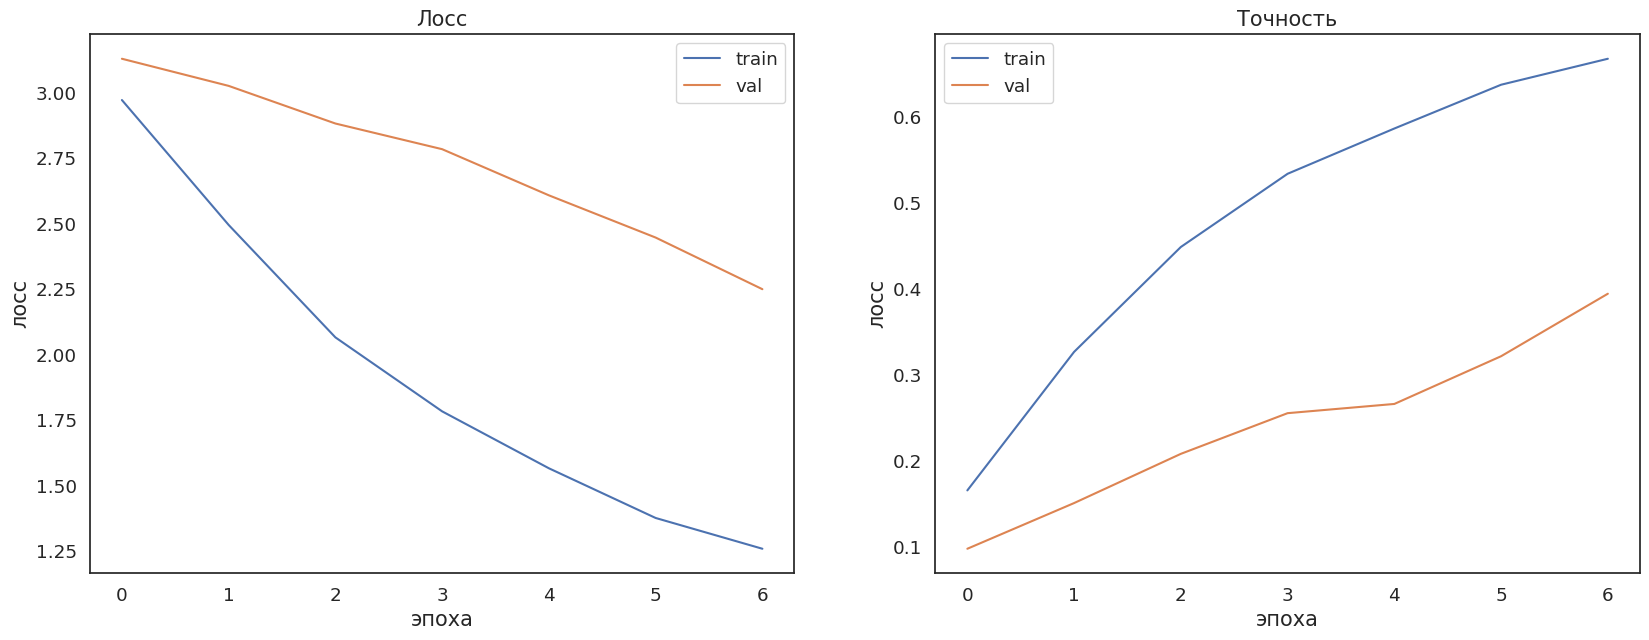

In [ ]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen_augm, val_batch_gen,
    num_epochs=10)

Ресурсов Colab хватило только на 7 эпох обучения на GPU, но уже в этом случае видно, что качество модели на валидации значительно хуже чем у модели, обученной на практике.

Кроме того, разница метрик для train и val достаточно большая, это может означать переобучение, то есть модель хорошо изучила искаженные тренировочные данные, а адекватные данные для валидации она уже не способна так хорошо распознать.

Итоговое качество на валидации обученной на практическом занятии модели составляло для 7 эпохи примерно 48 % (val_loss примерно 1.9). В данном случае для 7 эпохи точность 39.43 % (val_loss 2.250145).

Для наглядности графики метрик обученной на практическом занятии модели:

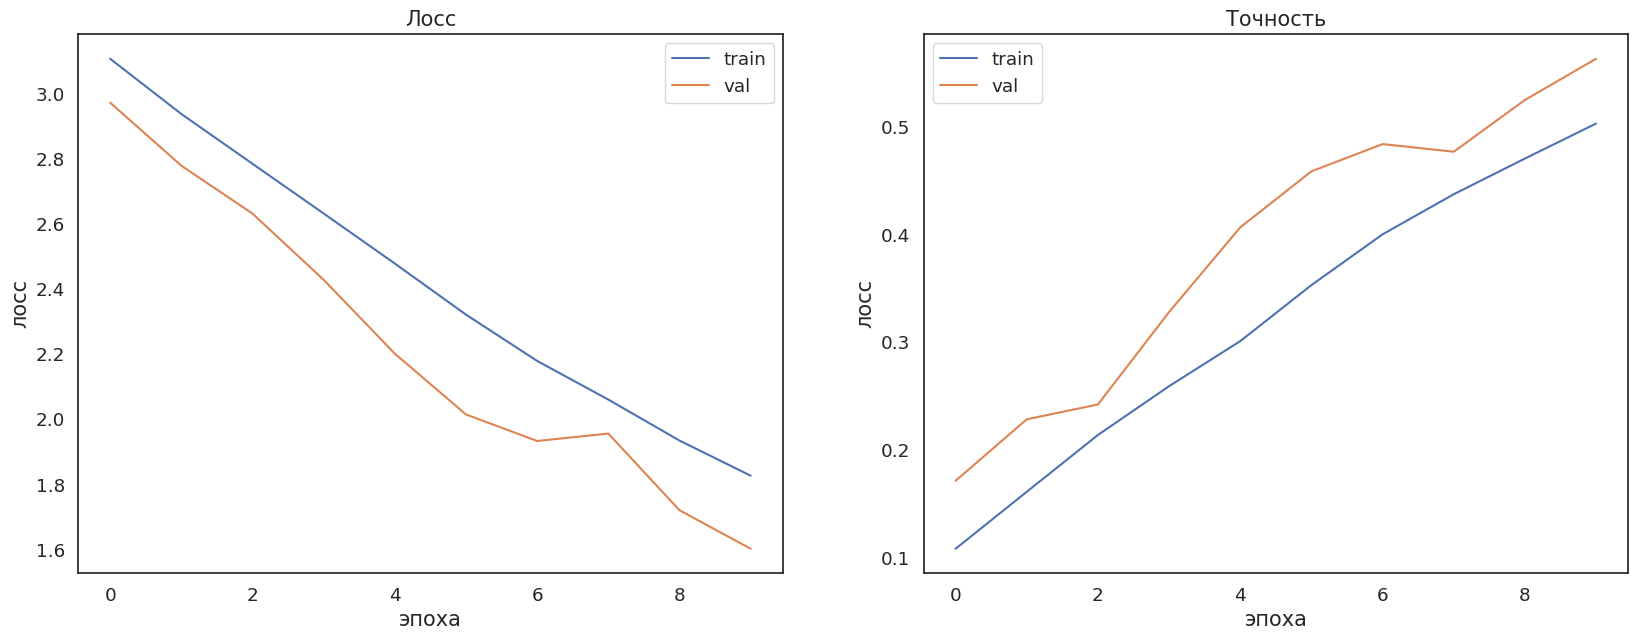

# 5. VGG16

## Feature extractor

Epoch 5 of 5 took 225.719s
  training loss (in-iteration): 	2.344501
  validation loss (in-iteration): 	1.973732
  training accuracy: 			35.19 %
  validation accuracy: 			49.21 %


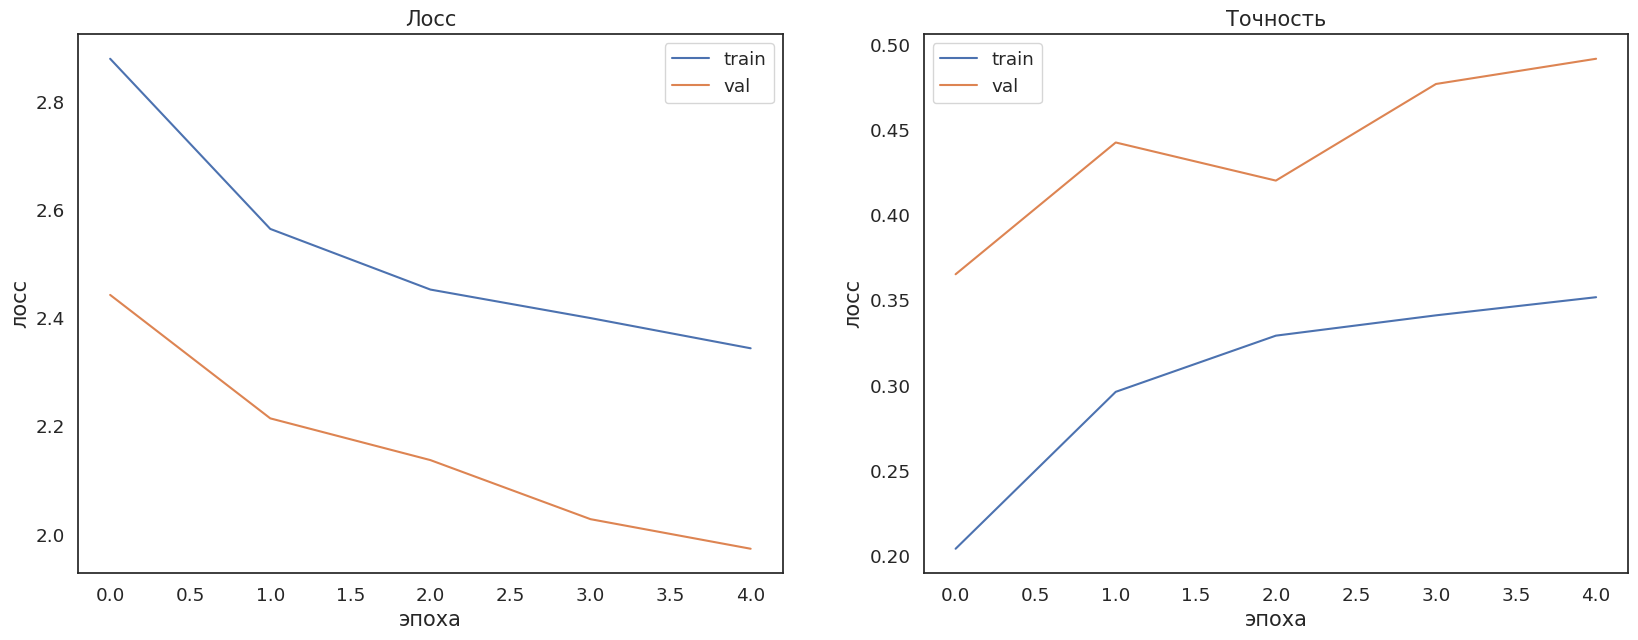

In [14]:
model_vgg_fe = vgg16(pretrained=True)

for param in model_vgg_fe.parameters():
    param.requires_grad = False

model_vgg_fe.classifier[6] = nn.Linear(4096, 42)
model_vgg = model_vgg_fe.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_vgg_fe.parameters(), lr=0.01)

clf_model_vgg_fe, history_vgg_fe = train(
    model_vgg_fe, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=5)

## Fine-tuning

Epoch 5 of 5 took 368.473s
  training loss (in-iteration): 	0.433470
  validation loss (in-iteration): 	0.334098
  training accuracy: 			88.55 %
  validation accuracy: 			91.48 %


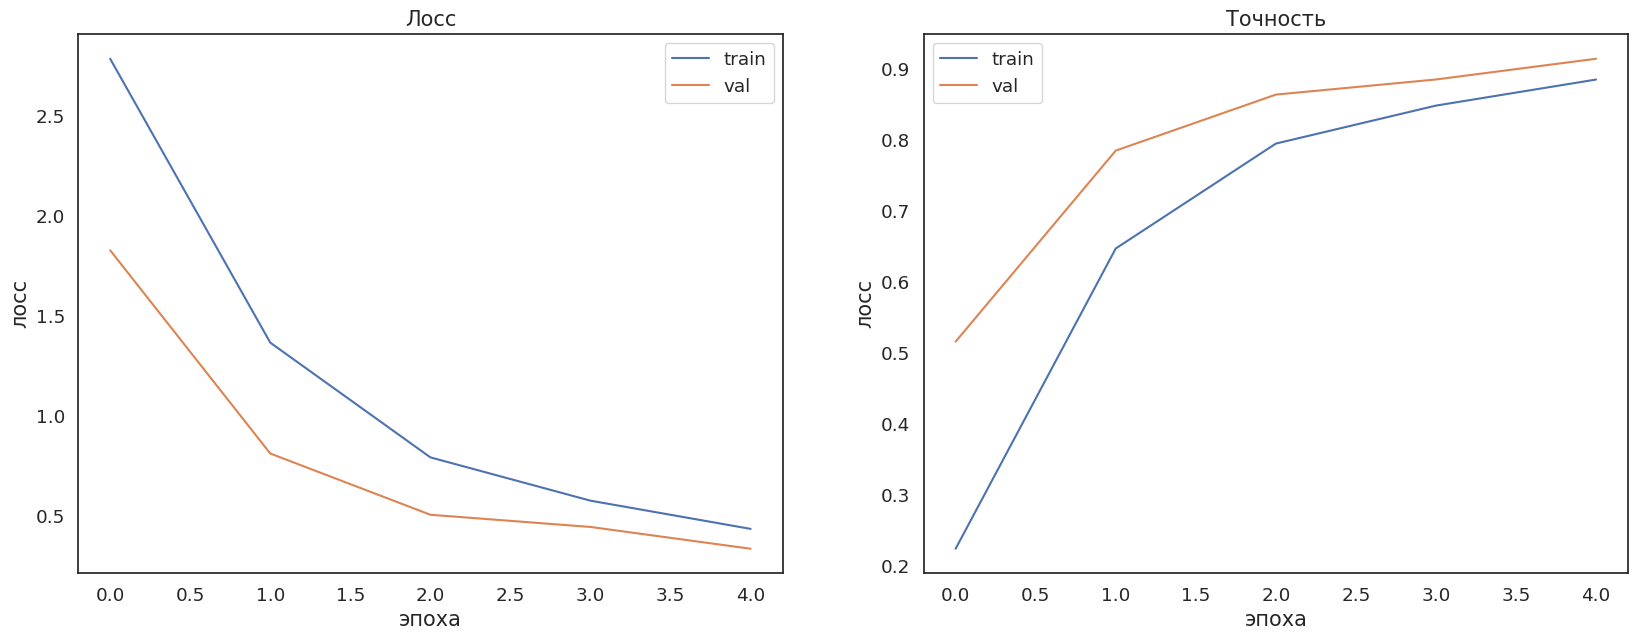

In [15]:
model_vgg_ft = nn.Sequential()
model_vgg_ft.add_module('vgg', vgg16(pretrained=True))
model_vgg_ft.add_module('flatten', nn.Flatten())
model_vgg_ft.add_module('fc_1', nn.Linear(1000, 512))
model_vgg_ft.add_module('relu_1', nn.ReLU())
model_vgg_ft.add_module('drop', nn.Dropout(0.5))
model_vgg_ft.add_module('fc_2', nn.Linear(512, 256))
model_vgg_ft.add_module('relu_2', nn.ReLU())
model_vgg_ft.add_module('fc_3', nn.Linear(256, 42))

model_vgg_ft = model_vgg_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_vgg_ft.parameters(), lr=0.01)

clf_model_vgg_ft, history_vgg_ft = train(
    model_vgg_ft, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=5)

В случае Fine-tuning уже на 2 эпохе обучения модель показывает результаты гораздо лучше чем в случае Feature extractor.

При этом в случа Feature extractor модель обучается немного быстрее.